# Coarse-Graining: Progress

## Two (visible) spins, coupled to a single hidden unit:

\begin{equation}
P\left(s_1,s_2,\sigma\right) = \frac{1}{Z} e^{(J_0 + J_1 s_1 + J_2 s_2)\sigma}; \mbox{  } \lbrace s_1, s_2, \sigma \rbrace=\lbrace \pm 1 \rbrace
\end{equation}


Must find $J_0$, $J_1$, $J_2$ such that:

\begin{align*}
    \tanh^2 {J_0} &= \frac{\langle s_1 \rangle \langle s_1 \rangle}{\langle s_1 s_2 \rangle} \\   
    \tanh^2 {J_1} &= \frac{\langle s_1 \rangle \langle s_1 s_2 \rangle}{\langle s_2 \rangle}  \\ 
    \tanh^2 {J_2} &= \frac{\langle s_2 \rangle \langle s_1 s_2 \rangle}{\langle s_1 \rangle}
\end{align*}


### Solutions are contingent on sign consistency.
While $\langle s_1 \rangle$ and $\langle s_1 \rangle$ will be negative in a neuroscience context (sparse firing assumption), having $\langle s_1s_2 \rangle<0$ simultaneously is problematic.


### Are we assured that $\langle s_1 s_2 \rangle >0$?


Consider two binary random variables $x$ and $y$. Let

\begin{align*}
    P(x=1) &= p  \\
    P(y=1) &= q   \\
    P(x=1, y=1) &= r
\end{align*}

so that 

\begin{align*}
    \langle x \rangle &= (-1)P(x=-1) + (1)P(x=1) = (1-p) + p = 2p-1 \\  
   \langle y \rangle &= (-1)P(y=-1) + (1)P(y=1) = (1-q) + q = 2q-1;
\end{align*}

then we can write the expectation of $x \cdot y$ (pairwise corelation)

\begin{align*}
    \langle xy \rangle &= (-1)\left(P(x=1,y=-1) + P(x=-1,y=1)\right) + (1)\left(P(x=1,y=1)+ P(x=-1,y=-1)\right) \\
     &= (-1)\left((p-r) + (q-r)\right) + (1)\left((r)+ (1-p-q+r)\right) \\
     &= -\left(p + q -2r)\right) + \left(1-p-q+2r\right) \\
     &= 4r-2p-2q+1.
\end{align*}


Since we want $\langle xy \rangle >0$, we have

\begin{align*}
    4r-2p-2q+1 &> 0 \\
    4r &> 2p+2q-1 \\
    r &> \frac{p+q}{2} - \frac{1}{4}.
\end{align*}

That is, the parameter $r$ must be greater than the average of $p$ and $q$, minus $\frac{1}{4}$. Let $x \rightarrow s_1$ and $y \rightarrow s_2$.

In our neuroscience applications, we can assume both $p$ and $q <0.25$ because neurons fire very sparsely.

Thus in order for $\langle s_1 s_2 \rangle >0$, we only need r to be greater than a negative number.

But this is always true for $\frac{p+q}{2}<=\frac{1}{4}$, because as a probability $r>0$ by definition.

QED

We choose the following convention:
\begin{align*}
    J_0 &=  - \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 \rangle}{\langle s_1 s_2 \rangle}}} \\   
    J_1 &= +  \tanh^{-1}{\sqrt{\frac{\langle s_1 \rangle \langle s_1 s_2 \rangle}{\langle s_2 \rangle}}}  \\ 
    J_2 &= + \tanh^{-1}{\sqrt{\frac{\langle s_2 \rangle \langle s_1 s_2 \rangle}{\langle s_1 \rangle}}}
\end{align*}


## 1. Prepare the data

### We load data from salamander retina -- say, the last trial out of 297.
### We store the firing trajectories (spike trains) for each of the N=160 neurons.

In [35]:
%CGpipeline_
close all; clear; clc; %CGpipeline_

 
%Load neural data
load bint_fishmovie32_100
data =reshape(bint(1,:,:),[160,953]);
data=data*2-1;
mean(sum(data>0,2)/953);  %Check the value of "p", how many times spiking
mean(mean(data,2));       %Check the value of <x>, the average firing rate


%CHOOSE THE NUMBER OF CG ITERATIONS !
%Number of times to apply above transformation
% Pre-allocate space for saving each GC step
CGevents=70;            %Number of iterations
C{1,CGevents+1}=[];    %Empty cell array to contain the coarsened data matrix at each step
C{1}=data;             %First element of cell array (i.e., 1st cell)--> original data matrix


%Begin a new cell array containing the "included" neuron trajectories (which will change)
for g=1:size(C{1},1)
  c{g}=C{1}(g,:);       %Break down each neuron's trajectory as member in a small cell array
end
D{1}=c;                 %Bigger cell array whose first element is "c", keeps track over iterations
E{1}=c;
%masterlist{1}=c;
incl{1}=1:length(c);
incl_origonly{1}=1:length(c);
%eliminated{1}=[];


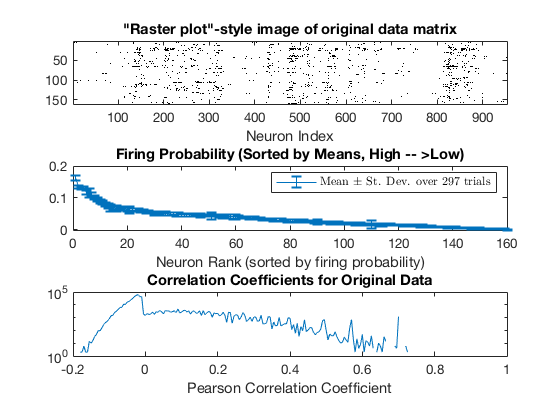

In [36]:

%"Raster plot"-style image of original data matrix
subplot(3,1,1)
imagesc(C{1})
colormap(flipud(gray))
title('"Raster plot"-style image of original data matrix')
xlabel('Neuron Index')



[meanz,indz]=sort(mean((mean(bint,3))),'descend');
varz=var((mean(bint,3)));
stdz=std((mean(bint,3)));

%Mean and St. Deviation of Individual Firing Rates
subplot(3,1,2)
errorbar(1:160,meanz,stdz(indz))
title('Firing Probability (Sorted by Means, High -- >Low)')
xlabel('Neuron Rank (sorted by firing probability)')
%ylabel('Percentage of time bins in which neuron was firing')
legend('Mean $\pm$ St. Dev. over 297 trials','interpreter','latex')

%Correlations for pairs of Firing Rates
subplot(3,1,3)
u=histogram(corrcoef(C{1}));
semilogy(u.BinEdges(1:end-1),u.Values)
title('Correlation Coefficients for Original Data')
xlabel('Pearson Correlation Coefficient')


## 2. Perform the Coarse-Graining using analytical solution

### Take pair $s_1,s_2$ with highest $cov = \langle s_1 s_2 \rangle - \langle s_1 \rangle \langle s_2 \rangle$; replace with a new "effective" neuron $\sigma$.
### Effective neurons have their own distribution (can measure $\langle 
\sigma \rangle $) which reproduces $\langle s_1 \rangle$, $\langle s_2 \rangle$, and $\langle s_1 s_2\rangle$.
### Do this for  $CGevents$ iterations or until the above assumptions about the distributions are broken ($\rightarrow$ exit loop).

In [37]:

for k=1:CGevents
    
    %k
    
[mosthigh,hival]=find_most_highly(data);
MostHi(k,:)=mosthigh;
eliminated{k}=incl{k}(mosthigh);

v1=data(mosthigh(1),:); v2=data(mosthigh(2),:);
means=[mean(data(mosthigh(1),:)) mean(data(mosthigh(2),:))];
pairwise=mean(data(mosthigh(1),:).*data(mosthigh(2),:));
covarnce=pairwise-mean(data(mosthigh(1),:))*mean(data(mosthigh(2),:));
%[means pairwise covarnce]

%Break the loop if <s_1*s_2> is negative or zero
if pairwise<=0
    fprintf('Non-positive pairwise correlation')
    k
    CGevents=k-1;
    break   %Violates assumptions; stop here
end


%Analytical solution equations
tanhJ0sqd=means(1)*means(2)/pairwise;
tanhJ1sqd=means(1)*pairwise/means(2);
tanhJ2sqd=means(2)*pairwise/means(1);



%Break the loop if any of above is >1
if sum([tanhJ0sqd tanhJ1sqd tanhJ2sqd]>1)
    fprintf('Error: Component > 1')
    k
    CGevents=k-1;
    break
end


%Choose values of couplings (interdependent, from each other)
J0=atanh(-tanhJ0sqd^.5);       %choose minus root as default
%J1=atanh(tanhJ1sqd^.5);
J1=atanh(means(1)/tanh(J0));
%J2=atanh(tanhJ2sqd^.5);
J2=atanh(pairwise/tanh(J1));
%mean(v1)^2+mean(v2)^2
%[tanhJ0sqd tanhJ1sqd tanhJ2sqd]

%Correlation for current pair -- check
corry=(pairwise-mean(v1)*mean(v2))/sqrt(var(v1)*var(v2));
[J0 J1 J2];


%In case any of above didn't catch it...
if sum((imag([J0 J1 J2]))>0)
    fprintf('Imaginary couplings')
    k
    CGevents=k-1;
    break

end


logistic_through         %Calculate sigma (hidden) from v1,v2; then in reverse
Meansig(k)=meansig;

newsigs{k}=samples;

%Save couplings each iteration
couplings(k,:)=[J0 J1 J2];
covthrutime(k)=covarnce;

 

%Compare probability distribution ((1,1),(1,-1),(-1,1), & (-1,-1))
%s_1 and s_2 with reconstruction for a given CG iteration
%fprintf('Individual reconstructions: sample stats')
JPD_compar(:,:,k)=[[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953; [sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953];
%figure
%bar(JPD_compar(:,:,k)')
%abs(JPD_compar(1,:,k)-JPD_compar(2,:,k))
%errorbar(mean(JPD_compar(:,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))

%errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
%hold on
%errorbar(mean(JPD_compar(2,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3))
 

%figure
%bar(1:4,[sum((v1+v2)==2) sum((v1==1) & (v2==-1)) sum((v1==-1) & (v2==1)) sum((v1+v2)==-2)]/953,0.5,'FaceColor',[0.2 0.2 0.5]); hold on
%bar(1:4,[sum((vis(1,:)+vis(2,:)==2)) sum((vis(1,:)==1) & (vis(2,:)==-1)) sum((vis(1,:)==-1) & (vis(2,:)==1)) sum((vis(1,:)+vis(2,:))==-2)]/953,.25,'FaceColor',[0 0.7 0.7])




c{size(c,2)+1}=samples;

incl{k+1}=setdiff(1:length(c),cell2mat(eliminated));

data=cell2mat(c(incl{k+1})');

end

incl=incl(1:CGevents);
eliminated=eliminated(1:CGevents);

Error: Component > 1
k =

    64



### Visualization: Neurons included after each CG step
Working on making a nicer picture which shows explicitly how we form a hierarchical RBM-style network, with couplings and all.

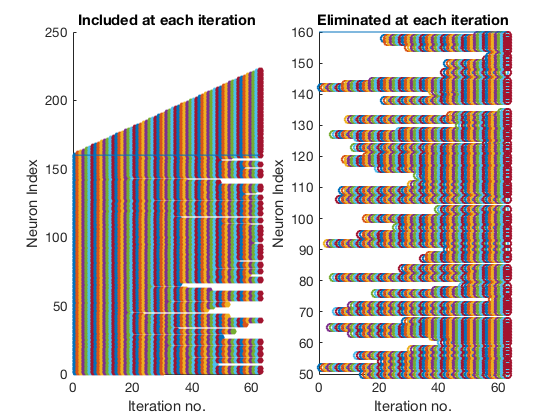

In [38]:
for k=1:CGevents

  subplot(1,2,1)
  scatter(k*ones(1,length(incl{k}(:))),incl{k}(:),25,'filled')
  hold on
  ylabel('Neuron Index')
  xlabel('Iteration no.')
  title('Included at each iteration')
  refline(0,160)
  
  subplot(1,2,2)
  scatter(k*ones(1,length(cell2mat(eliminated(1:k)))),cell2mat(eliminated(1:k)))
  ylabel('Neuron Index')
  xlabel('Iteration no.')
  title('Eliminated at each iteration')
  hold on
  refline(0,160)
  
end

In [48]:
e=cell2mat(eliminated);
E=cell2mat(eliminated');
F=[E (161:160+CGevents)'];

J=zeros(160+CGevents);
pos=[ones(1,160)' [1:160]'];

[Au,~,ic] = unique(E);
                   tally = accumarray(ic, 1);
                   Result = [Au tally];
                   %size(tally)
                   
                   
for k=1:CGevents

  k;

  for j=1:2
  
  j;
  
      J(E(k,j),160+k)=1;
      J(160+k,E(k,j))=1;
      
  end
      
      if  sum(E(k,:)>160)==0
      
          pos(160+k,:)=[2 160+k];
      
      elseif sum(tally(find(ismember(Result(:,1),E(k,:)))))==2
      
          pos(160+k,:)=[3 160+k];
       
      else sum(tally(find(ismember(Result(:,1),E(k,:)))))~=2
      
       fprintf('Something happened... duplicate entry.')
       k
       break   %Violates assumptions; stop here
       
      end


 end     
      
      

In [49]:
E


E =

    52   142
    22    20
    92    25
    34    65
   127    81
    29    70
    46   106
   109     8
   119   143
   118   132
    72    63
   123    11
   126    56
    44    95
    48    50
   100   120
    26    41
    45   144
    76    28
   116    30
    54    94
   158   138
    43   157
    40    37
    38    17
    64    97
   128    12
    84    99
    67    35
     1   155
    58   111
    21    53
    33   114
     5   115
    32    87
   113    66
   122    88
   141    62
    13    77
   103     9
     3    60
   147   139
   150    90
   133    16
    47     6
    61    71
    49   130
    78     7
   140   156
    27   110
   149    82
    42    51
    18   159
    31    57
   101    83
   151   124
   131   152
    36    74
    73   108
   161    96
   134   174
   154   162
    23   194



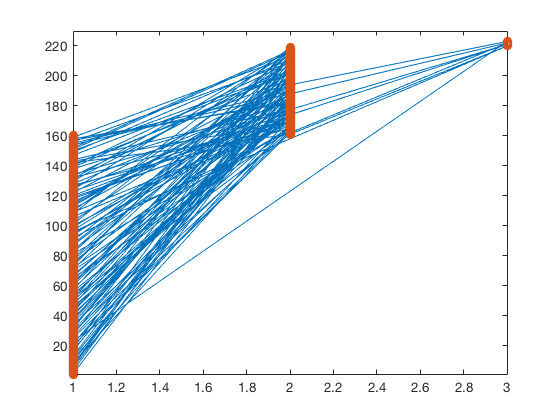

In [50]:
gplot(J,pos)
hold on
scatter(pos(:,1),pos(:,2))
ylim([1 230])
%refline(0,213)
%refline(0,160)

## 3. Reconstruct the data

### Iteration by iteration in reverse, we replace (a copy of) the trajectories for each of the subset of the $CGevents+N$ neurons that were coarse-grained by new trajectories, reconstructed from effective neurons that replaced them.

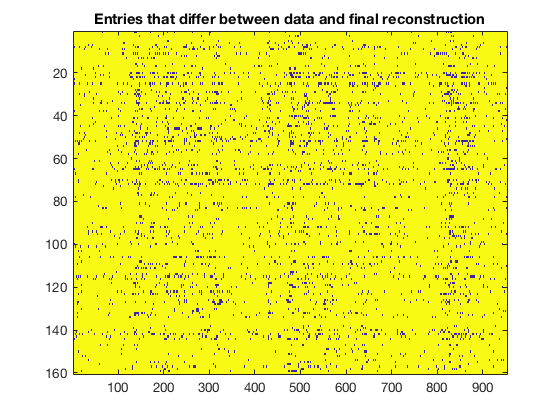

In [51]:
r=c;

for k=CGevents:-1:1
    
%k
%eliminated{k}

activ=[r{160+k}; r{160+k}].*couplings(k,2:3)';
recons=(exp((activ))./(2.*cosh(activ))>rand(2,num_samps))*2-1;
r(eliminated{k})={recons(1,:),recons(2,:)};

%sum((sum(cell2mat(c')==cell2mat(r'),2)/953)<1)

end

figure
imagesc(cell2mat(c(1:160)')==cell2mat(r(1:160)'))
title('Entries that differ between data and final reconstruction')
%Also, plot "affected rows/cols" of correlation matrices?

%Can also do:
%Pick k, see how reconst elements differ from originals
%imagesc(cell2mat(r(incl{k})')==cell2mat(c(incl{k})'))

## 4. Compute correlation/covariance matrixes:

### Are the most highly correlated neurons the same in original, coarsened, and reconstructed matrices?

(Need to define "receptive fields" more precisely. Going to try definition from Mehta and Schwab 2014.)

### Covariance $\mbox{ } cov(s_1,s_2) = \langle s_2 s_2 \rangle - \langle s_1 \rangle  \langle s_2 \rangle $

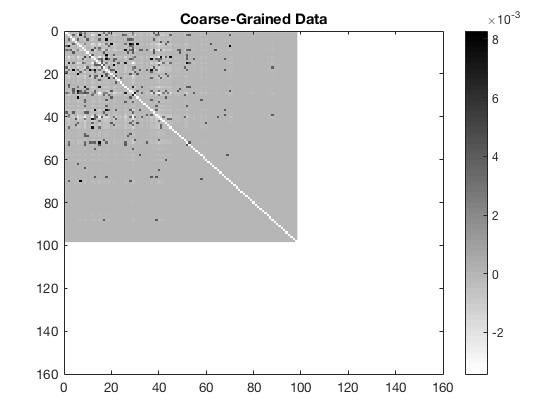

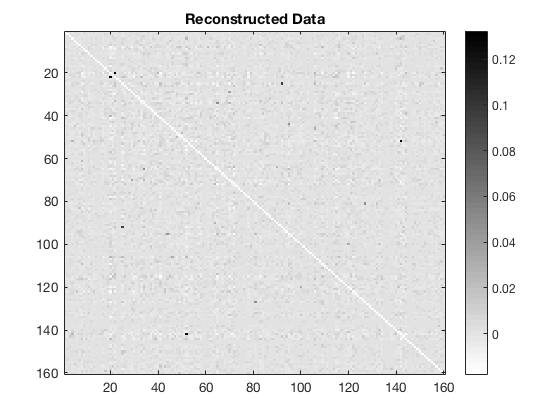

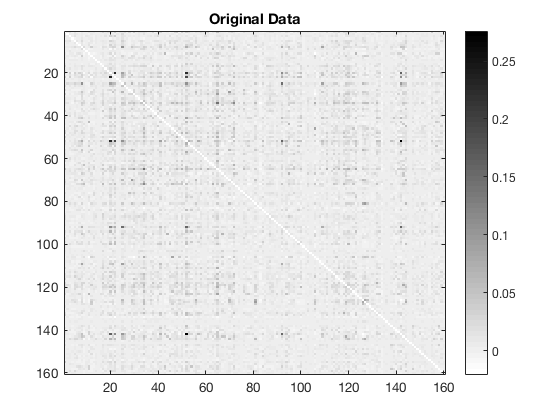

In [52]:
%Compute the covariance matrixes:
        
    %[covC_raw,covC]=cov_matrix(C{1});
    [covDat_raw,covDat]=cov_matrix(cell2mat(c(incl{1})'));
    [covRec_raw,covRec]=cov_matrix(cell2mat(r(incl{1})'));
    [covCG_raw,covCG]=cov_matrix(cell2mat(c(incl{end})'));
    
    %figure,imagesc(covC); title('Original Data Matrix')
    figure,imagesc(covDat); title('Original Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covRec); title('Reconstructed Data'); colormap(flipud(gray)); colorbar
    figure,imagesc(covCG); title('Coarse-Grained Data'); colormap(flipud(gray)); colorbar
    xlim([0 160]); ylim([0 160])

## 5. Sanity check: Which are the most correlated pairs?

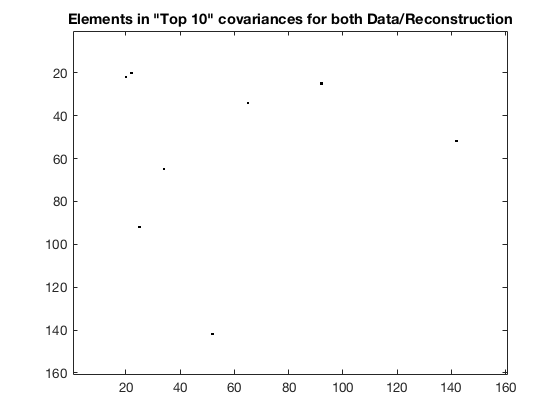

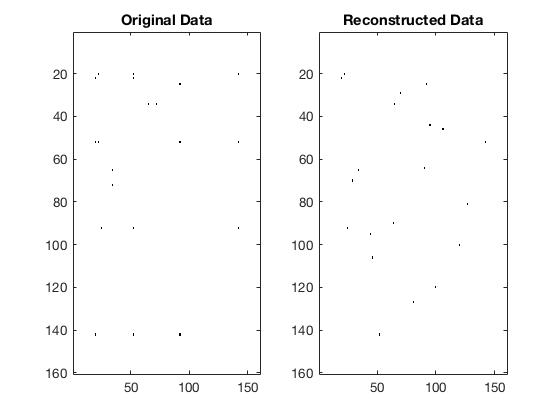

In [53]:
%Find the locations of the most highly correlated in original data, coarse-grained, and final reconstructions, in order.
    
    howmanytop=10;  %Top __ covariance entries (in data/recons)
    
    [covDat_unique indD]=sort(unique(covDat(~isnan(covDat))),'descend');
    covDat_top=covDat_unique(1:howmanytop);
    [rD,cD]=find(ismember(triu(covDat),covDat_top(1:howmanytop)));
    
    [covRec_unique]=sort(unique(covRec(~isnan(covRec))),'descend');
    covRec_top=covRec_unique(1:howmanytop);
    [rR,cR]=find(ismember(triu(covRec),covRec_unique(1:howmanytop)));

    
    %Lists of top entries and locations
    
    for topindsD=1:howmanytop
        topsD(topindsD)=covDat(rD(topindsD),cD(topindsD));
    end
        [topsD,indsD]=sort(topsD','descend');
        rD=rD(indsD); cD=cD(indsD);
    
    for topindsR=1:howmanytop
        topsR(topindsR)=covDat(rR(topindsR),cR(topindsR));
    end
        [topsR,indsR]=sort(topsR','descend');
        rR=rR(indsR); cR=cR(indsR);
    
    
         
    %Side-by-side plot of top cov's for original data vs. recons
    figure
    subplot(1,2,1)
    imagesc(covDat>=covDat_top(end)); colormap(flipud(gray));
    title('Original Data')
    subplot(1,2,2)
    imagesc(covRec>=covRec_top(end)); colormap(flipud(gray));
    title('Reconstructed Data')
    %Should add covCG!!!
    
    
    %figure,imagesc(covRec>=covRec_top(end) == covDat>=covDat_top(end)); colormap(flipud(gray));
    figure,imagesc(((covRec>=covRec_top(end)) + (covDat>=covDat_top(end)))==2); colormap(flipud(gray));
    title('Elements in "Top 10" covariances for both Data/Reconstruction')

## 6. Average reconstruction error for JPD over {(1,1) (1,-1) (-1,1) (-1,-1)}
### Can view any value of $k$ from $1:CGevents$; here k=1 is just an example...

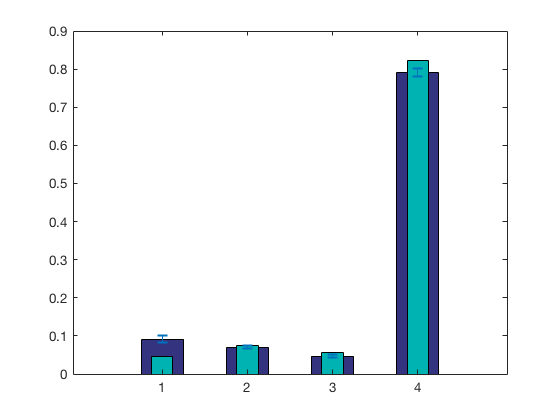

In [54]:
k=1;
%Joint probability distributions w/ error bars showing the mean difference between reconstruction and original data
bar(mean(JPD_compar(1,:,k),3),0.5,'FaceColor',[0.2 0.2 0.5]); hold on; bar(mean(JPD_compar(2,:,k),3),.25,'FaceColor',[0 0.7 0.7])
errorbar(mean(JPD_compar(1,:,k),3),mean(abs(JPD_compar(1,:,:)-JPD_compar(2,:,:)),3),'LineStyle','none','MarkerSize', 20)

## Questions

	
* ### What next to quantitatively measure reconstruction quality?

    * 3rd-order stats?
    * Mutual Information
    * Look at Leenoy's work
	
* ### One pair at a time -- still good? How arrange network "layers"?


### Mutual Information

In [55]:
for m=1:160
for n=1:160

    data=C{1}([m n],:)';
    MI_Dat(m,n)=mutual_stats(data);

end
end


In [56]:
Recmat=cell2mat(r(incl{1})');

for m=1:160
for n=1:160

    data=Recmat([m n],:)';
    MI_Rec(m,n)=mutual_stats(data);

end
end

In [57]:
mean(mean(MI_Dat))
mean(mean(MI_Rec))


ans =

    0.0036


ans =

    0.0017



## Mutual information comparison plot ("data with data" vs. "data with reconstruction").

The idea is to see how well matching the means/pairwise stats recover the information about higher-order interactions.

I have thought about, and made other plots with, "benchmarks" against which to compare -- for example, how about plotting another scatter for the MI values that would be estimated using the sample method for 160 independent Bernoulli variables that have the same means as the reconstructed spins? Let me know.

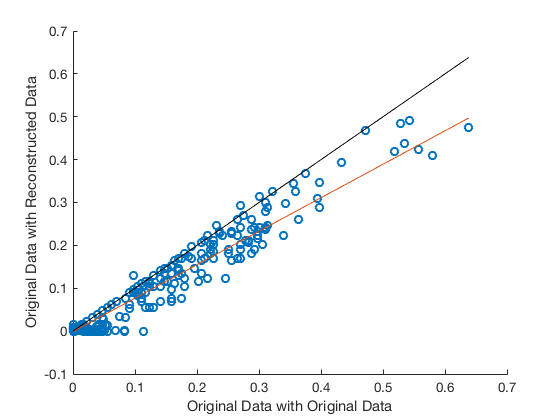

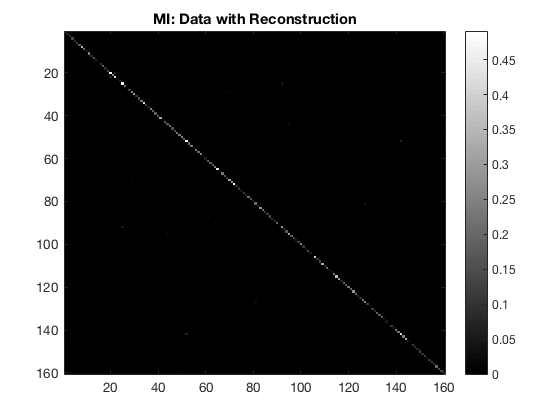

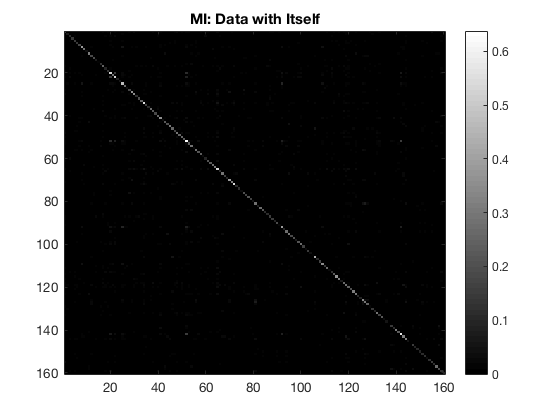

In [58]:
figure,imagesc(MI_Dat); title('MI: Data with Itself'); colormap(gray); colorbar
figure,imagesc(MI_Rec); title('MI: Data with Reconstruction'); colormap(gray); colorbar

figure,scatter(MI_Dat(:),MI_Rec(:))
hold on
linfit=polyfit(MI_Dat(:),MI_Rec(:),1);
yfitvals=polyval(linfit,MI_Dat(:));
plot(MI_Dat(:),yfitvals);
plot(MI_Dat(:),MI_Dat(:),'k')
xlabel('Original Data with Original Data')
ylabel('Original Data with Reconstructed Data')
hold off

### With the diagonals removed:

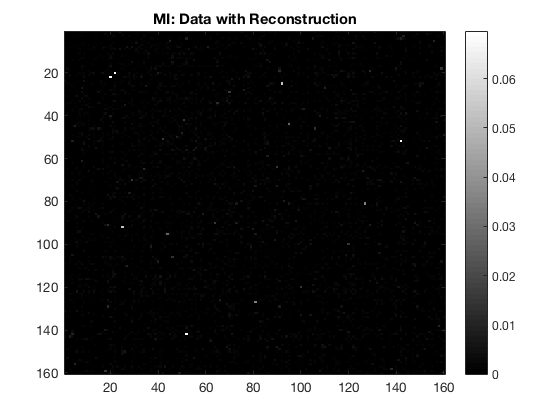

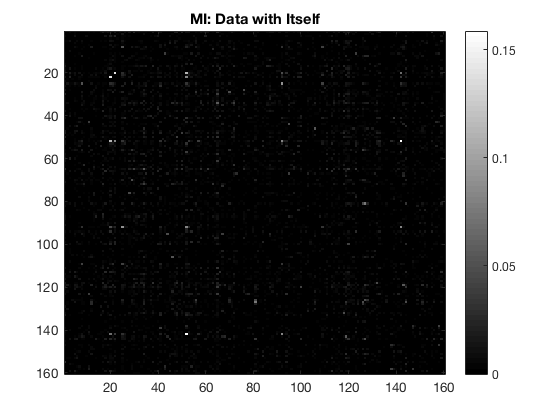

In [60]:


MI_Dat=MI_Dat.*(diag(ones(1,size(MI_Dat,1))*nan)+1);
MI_Rec=MI_Rec.*(diag(ones(1,size(MI_Rec,1))*nan)+1);

figure,imagesc(MI_Dat); title('MI: Data with Itself'); colormap(gray); colorbar
figure,imagesc(MI_Rec); title('MI: Data with Reconstruction'); colormap(gray); colorbar




## Update: Post-Group Meeting
Michael and others suggested simply looking at a histogram of the differences between the covariance elements of the original data and reconstructed matrices. This is shown below, but I had intially abandoned the idea because I wanted to find a more quantitative measure/summary ... from my perspective, the numbers on the x-scale below have no meaning. Ahmed suggested simply normalizing by the average covariance value. However, there are problems with doing this naively... and again, this would make sense to me only if it were a normalized covariance (i.e., Pearson correlation) matrix, and even then I am having trouble justifying such a metric because I need to think more about/discuss with you what it is we really want to preserve/predict/learn about the neural system.

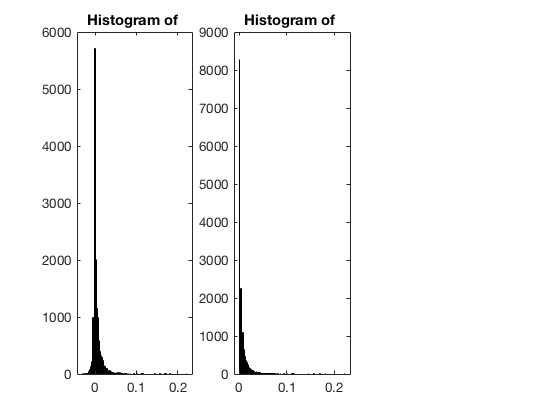

In [61]:
subplot(1,3,1)
histogram(covDat-covRec)
title('Histogram of ')

subplot(1,3,2)
histogram(abs(covDat-covRec))
title('Histogram of ')

In [73]:
save('forgrpmtg_Apr18')

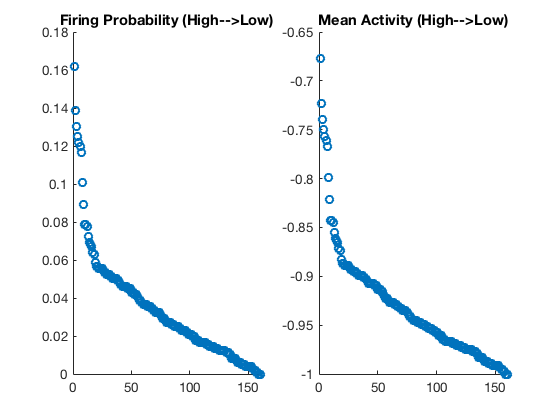

In [64]:
subplot(1,2,1)
scatter(1:160,sort(sum(C{1}>0,2)/953,'descend'))
title('Firing Probability (High-->Low)')

subplot(1,2,2)
scatter(1:160,sort(mean(C{1},2),'descend'))
title('Mean Activity (High-->Low)')

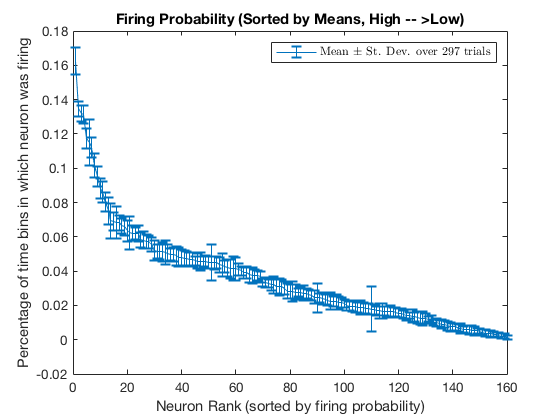

In [65]:
[meanz,indz]=sort(mean((mean(bint,3))),'descend');
varz=var((mean(bint,3)));
stdz=std((mean(bint,3)));


figure
errorbar(1:160,meanz,stdz(indz))
title('Firing Probability (Sorted by Means, High -- >Low)')
xlabel('Neuron Rank (sorted by firing probability)')
ylabel('Percentage of time bins in which neuron was firing')
legend('Mean $\pm$ St. Dev. over 297 trials','interpreter','latex')

In [66]:
size(C{1}')
size(cell2mat(r(incl{1})')')

size([C{1}'; cell2mat(r(incl{1})')'])
congl=[C{1}'; cell2mat(r(incl{1})')'];


ans =

   953   160


ans =

   953   160


ans =

        1906         160



In [67]:
1575-951


ans =

   624



In [78]:
[Au,~,ic] = unique(congl, 'rows');
                   tally = accumarray(ic, 1);
                   Result = [Au tally];
                   size(tally)


ans =

        1575           1



In [65]:
[Au,~,ic] = unique([C{1}'], 'rows');
                   tally = accumarray(ic, 1);
                   Result = [Au tally];
                   


ans =

   953



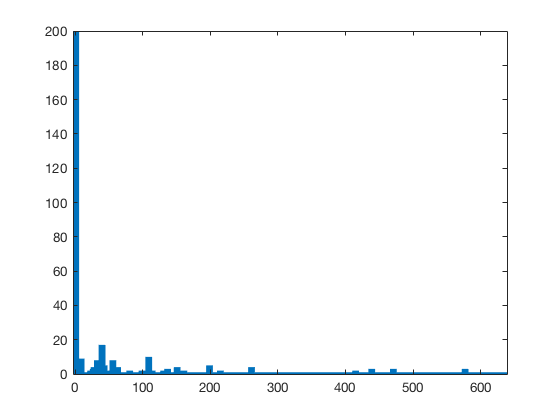

In [68]:
[U,~,c] = unique(C{1}', 'rows');
occ =accumarray(c, 1);
bar(1:length(occ),occ,10)
xlim([-3 length(occ)])
ylim([0 200])
sum(occ)


ans =

   953



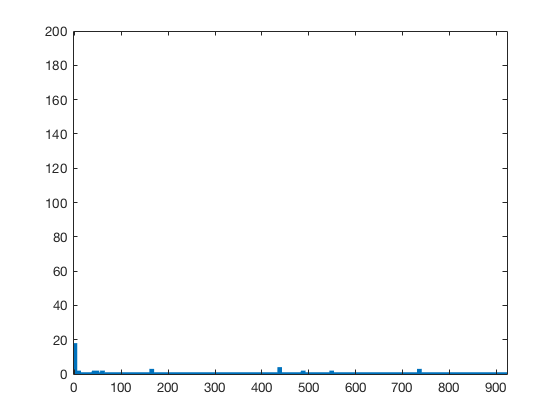

In [69]:
[U,~,c] =unique(cell2mat(r(incl{1})')','rows');
occ =accumarray(c, 1);
bar(1:length(occ),occ,10)
xlim([-3 length(occ)])
ylim([0 200])
sum(occ)

In [70]:
[a,ica,iaa]=unique(C{1}','rows');
[b,icb,iab]=unique(cell2mat(r(incl{1})')','rows');

In [71]:
size(a)
size(b)


ans =

   639   160


ans =

   923   160



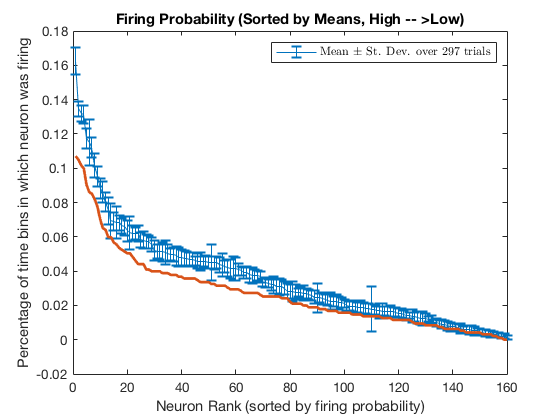

In [72]:
[meanz,indz]=sort(mean((mean(bint,3))),'descend');
varz=var((mean(bint,3)));
stdz=std((mean(bint,3)));


figure
errorbar(1:160,meanz,stdz(indz))
title('Firing Probability (Sorted by Means, High -- >Low)')
xlabel('Neuron Rank (sorted by firing probability)')
ylabel('Percentage of time bins in which neuron was firing')
legend('Mean $\pm$ St. Dev. over 297 trials','interpreter','latex')

hold on

plot(1:160,sort(sum(cell2mat(r(incl{1})')>0,2)/953,'descend'),'LineWidth',2)
title('Firing Probability (Sorted by Means, High -- >Low)')
xlabel('Neuron Rank (sorted by firing probability)')
ylabel('Percentage of time bins in which neuron was firing')
legend('Mean $\pm$ St. Dev. over 297 trials','interpreter','latex')